In [12]:
# ! pip install zarr

In [12]:
import allel
import zarr
import numpy as np
import matplotlib.pyplot as plt

def load_callset(callset_file, overwrite=False, **kwargs):
    if overwrite:
        allel.vcf_to_zarr(callset_file, f'{callset_file}.zarr', overwrite=True, **kwargs)
    callset = zarr.open_group(f'{callset_file}.zarr', mode='r')
    return callset

def get_gt_vsp(callset):
    return allel.GenotypeDaskArray(callset['calldata/GT'])

In [26]:
snp_indel_vcf_gz = '/home/jupyter/AoU1-v1/hiphase-outputs/chr1_scaffold.vcf.gz'
snp_indel_af_vcf_gz = '/home/jupyter/AoU1-v1/preprocess/chr1.snp_indel.af.vcf.gz'
sv_vcf_gz = '/home/jupyter/AoU1-v1/hiphase-outputs/chr1_finalsv_scaffold.vcf.gz'

In [13]:
concat_af_split_vcf_gz = '/home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.vcf'
concat_af_split_mergehap_vcf_gz = '/home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.mergehap.vcf.gz'
concat_af_split_mergehap_unmergehap_vcf = '/home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.mergehap.unmergehap.vcf'

In [3]:
# ! gsutil cp \
#     gs://fc-secure-f7d80b48-be60-426f-aa6b-f037a1bf7f34/scratch/slee/AoU1-v1/resources/*.chr1.preprocessed.split.vcf.gz* \
#     /home/jupyter/AoU1-v1/resources/
    
hgsvc2_vcf_gz = '/home/jupyter/AoU1-v1/resources/HGSVC2.chr1.preprocessed.split.vcf.gz'
kg_vcf_gz = '/home/jupyter/AoU1-v1/resources/1kg.chr1.preprocessed.split.vcf.gz'

In [16]:
def get_hist_data(callset_vcf_gz, overwrite=False):
    print(f'Loading {callset_vcf_gz}...')
    callset = load_callset(callset_vcf_gz, overwrite=overwrite, fields=['GT', 'altlen', 'samples', 'CHROM'])
    altlen = np.squeeze(callset['variants/altlen'][:])
    gt_vsp = get_gt_vsp(callset)
    num_alt_alleles_v = np.sum(gt_vsp.is_het() * 1 + gt_vsp.is_hom_alt() * 2, axis=1).compute()

    return altlen, num_alt_alleles_v, gt_vsp

In [17]:
def plot_hist_data(label, altlen, num_alt_alleles_v, gt_vsp, show=False):
    print(f'Plotting {label}...')
    bins = list(np.linspace(-10000, -100, 397)) + [-75, -50, -25, -1, -0.1, 0.1, 1, 25, 50, 75] + list(np.linspace(100, 10000, 397))
    plt.hist(altlen, bins=bins, label=label, log=True, histtype='step', alpha=0.5)#,
             #weights=num_alt_alleles_v)
    plt.xscale('symlog', linthresh=100)
    plt.xticks([-1E4, -1E3] + list(np.linspace(-100, 100, 9)) + [1E3, 1E4],
               labels=['$-10^4$', '$-10^3$', '$-10^2$'] + ['', '$-50$', '', '$0$', '', '$50$', ''] + ['$10^2$', '$10^3$', '$10^4$'])
    plt.ylabel('Number of ALT alleles')
    plt.xlabel('ALT length - REF length (bp)')
    
    if show:
        plt.legend()
        plt.show()

Loading /home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.vcf...
Plotting AoU1 (raw)...
Loading /home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.mergehap.vcf.gz...
Plotting AoU1...
Loading /home/jupyter/AoU1-v1/resources/HGSVC2.chr1.preprocessed.split.vcf.gz...
Plotting HGSVC2...
Loading /home/jupyter/AoU1-v1/resources/1kg.chr1.preprocessed.split.vcf.gz...
Plotting 1kGP-SV...


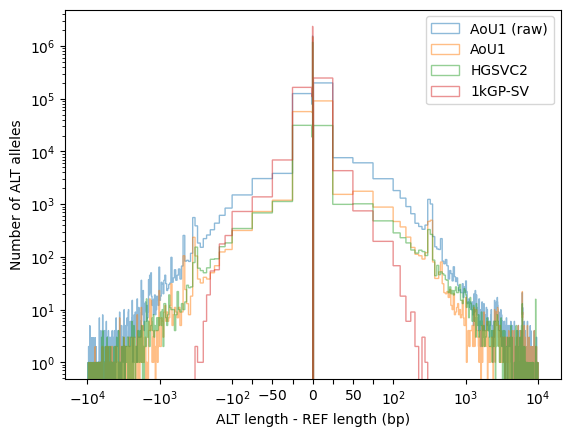

In [6]:
plot_hist_data('AoU1 (raw)', *get_hist_data(concat_af_split_vcf_gz))
plot_hist_data('AoU1', *get_hist_data(concat_af_split_mergehap_vcf_gz))
plot_hist_data('HGSVC2', *get_hist_data(hgsvc2_vcf_gz))
plot_hist_data('1kGP-SV', *get_hist_data(kg_vcf_gz), show=True)

Loading /home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.vcf...
Plotting AoU1 (raw)...
Loading /home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.mergehap.vcf.gz...
Plotting AoU1...
Loading /home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.mergehap.unmergehap.vcf...
Plotting AoU1 (unmerge)...


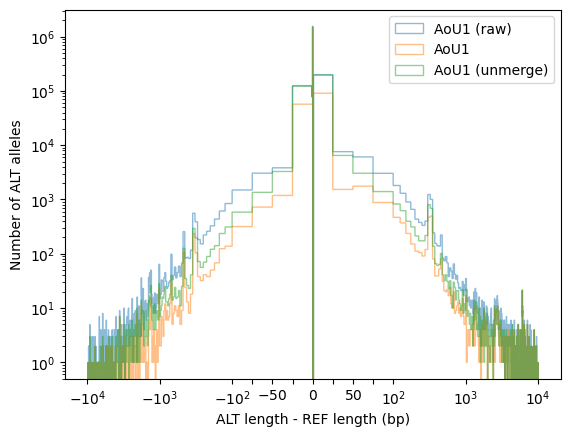

In [11]:
plot_hist_data('AoU1 (raw)', *get_hist_data(concat_af_split_vcf_gz))
plot_hist_data('AoU1', *get_hist_data(concat_af_split_mergehap_vcf_gz))
plot_hist_data('AoU1 (unmerge)', *get_hist_data(concat_af_split_mergehap_unmergehap_vcf, overwrite=True), show=True)

In [14]:
import matplotlib.colors

ternary_to_cartesian = lambda a, b, c: (0.5 * (2 * b + c) / (a + b + c + 1E-10), 0.5 * np.sqrt(3) * c / (a + b + c + 1E-10))

def calc_hwe_ternary(x, m=1, f=1):
    return np.array([1 - f, 0, 0]) + f * np.array([m * (1 - x)**2 + (1 - m) * (1 - x),   # hom ref
                                                   m * x**2 + (1 - m) * x,               # hom alt
                                                   2 * m * x * (1 - x)])                 # het

def make_de_finetti_ax(ax=None):
    if ax is None:
        ax = plt.axes(xlim=[-0.1, 1.1], ylim=[-0.1, np.sqrt(3) / 2 + 0.1])
    ax.set_aspect(np.sqrt(3) / 2)
    ax.axis('off')
    ep = 0.02
    ax.plot([-2 * ep / np.sqrt(3), 1 + 2 * ep / np.sqrt(3)], [-ep, -ep], lw=3, c='k')
    ax.plot([-2 * ep / np.sqrt(3), 0.5], [-ep, 0.5 * np.sqrt(3) + ep], lw=3, c='k')
    ax.plot([1 + 2 * ep / np.sqrt(3), 0.5], [-ep, 0.5 * np.sqrt(3) + ep], lw=3, c='k')
    ax.text(-4 * ep / np.sqrt(3), -4 * ep, 'HOM\nREF ', fontsize=16, ha='right')
    ax.text(0.5, 0.5 * np.sqrt(3) + 3 * ep, 'HET', fontsize=16, ha='center')
    ax.text(1 + 4 * ep / np.sqrt(3), -4 * ep, 'HOM\n ALT', fontsize=16, ha='left')
    return ax

def plot_de_finetti(ax, gt_vsp, title='', show=False, gridsize=70):
    def plot_curve(ax, c='C1', ls='solid', lw=1):
        x_values = np.linspace(0, 1, 50)
        cart_values = np.array([ternary_to_cartesian(*calc_hwe_ternary(x)) for x in x_values])
        ax.plot(cart_values[:, 0], cart_values[:, 1], c=c, ls=ls, lw=lw)
        
    num_hom_ref_v = gt_vsp.is_hom_ref().sum(axis=1)
    num_het_v = gt_vsp.is_het().sum(axis=1)
    num_hom_var_v = gt_vsp.is_hom_alt().sum(axis=1)
    x_ternary_v, y_ternary_v = ternary_to_cartesian(num_hom_ref_v, num_hom_var_v, num_het_v)
    
#     ax.scatter(x_ternary_v, y_ternary_v, s=1, alpha=0.5)
    plt.hexbin(x_ternary_v, y_ternary_v, gridsize=gridsize, extent=[0, 1, 0, np.sqrt(3) / 2], norm=matplotlib.colors.LogNorm())
    cbar = plt.colorbar(ax=ax, shrink=0.5)
    cbar.set_label('Number of variants', rotation=270, labelpad=10)
    plot_curve(ax, lw=3)
    
    ax.text(0.5, -0.3, title, fontsize=24, ha='center')
    if show:
        plt.show()
    return ax

Loading /home/jupyter/AoU1-v1/preprocess/chr1.snp_indel.af.vcf.gz...


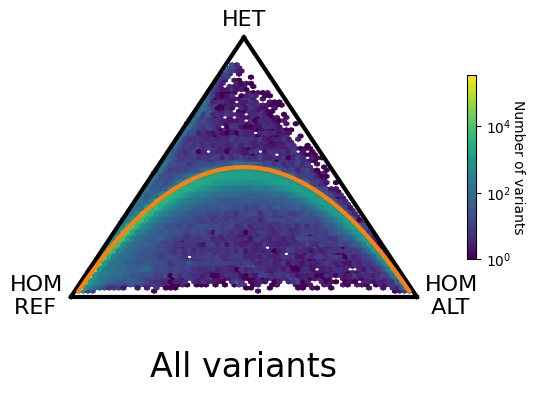

In [27]:
altlen, num_alt_alleles_v, gt_vsp = get_hist_data(snp_indel_af_vcf_gz, overwrite=True)

_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp, title='All variants', show=True)

Loading /home/jupyter/AoU1-v1/hiphase-outputs/chr1_finalsv_scaffold.vcf.gz...


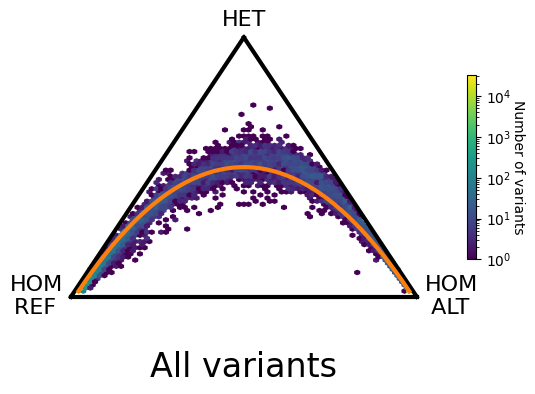

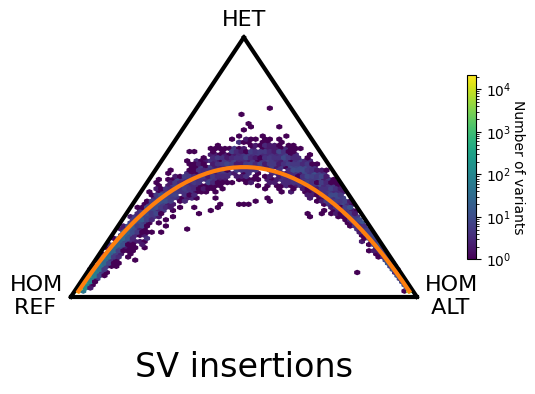

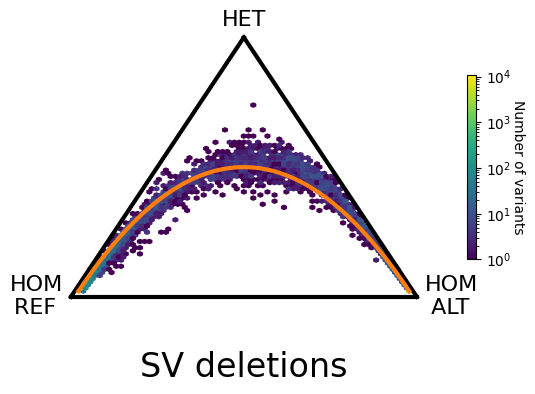

In [25]:
altlen, num_alt_alleles_v, gt_vsp = get_hist_data(sv_vcf_gz, overwrite=True)
is_sv_ins = altlen >= 50
is_sv_del = altlen <= -50

_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp, title='All variants', show=True)
_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp[is_sv_ins], title='SV insertions', show=True)
_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp[is_sv_del], title='SV deletions', show=True)

Loading /home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.vcf...


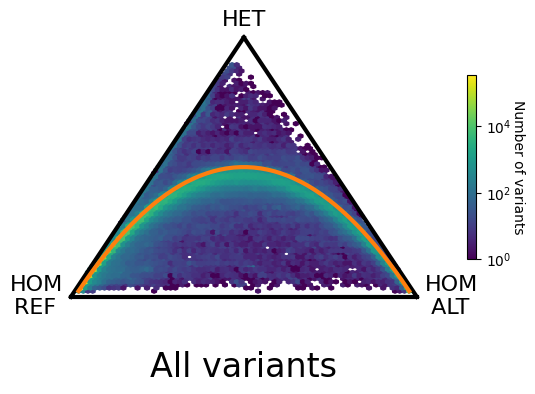

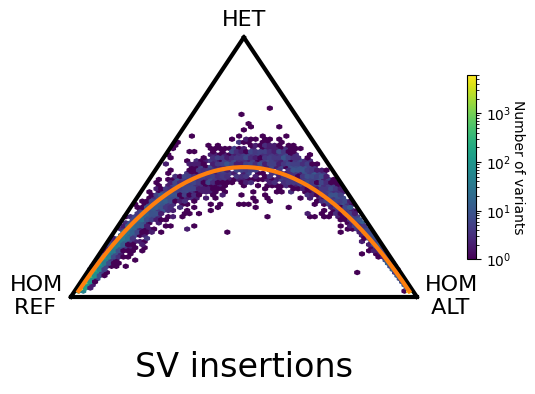

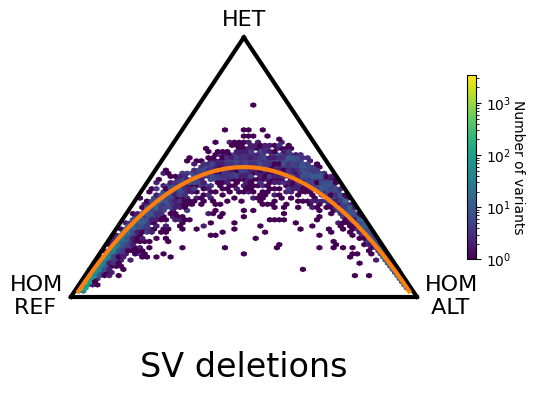

In [21]:
altlen, num_alt_alleles_v, gt_vsp = get_hist_data(concat_af_split_vcf_gz)
is_sv_ins = altlen >= 50
is_sv_del = altlen <= -50

_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp, title='All variants', show=True)
_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp[is_sv_ins], title='SV insertions', show=True)
_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp[is_sv_del], title='SV deletions', show=True)

Loading /home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.mergehap.vcf.gz...


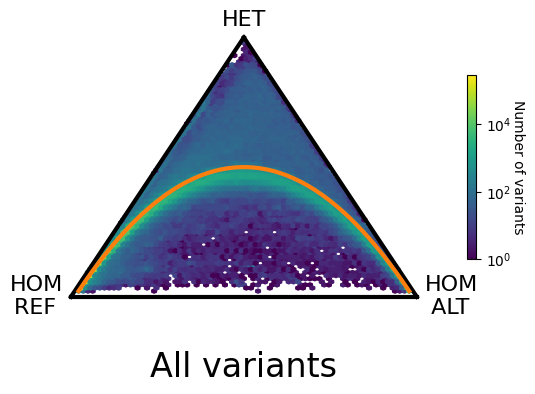

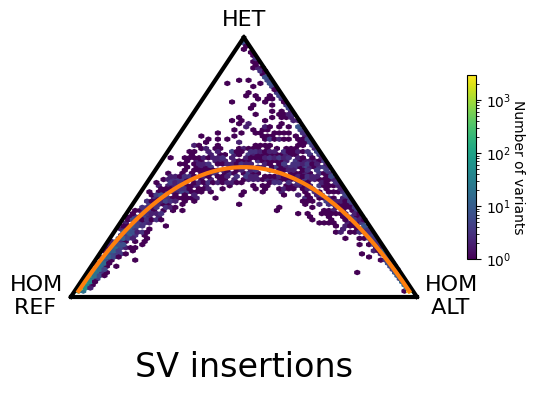

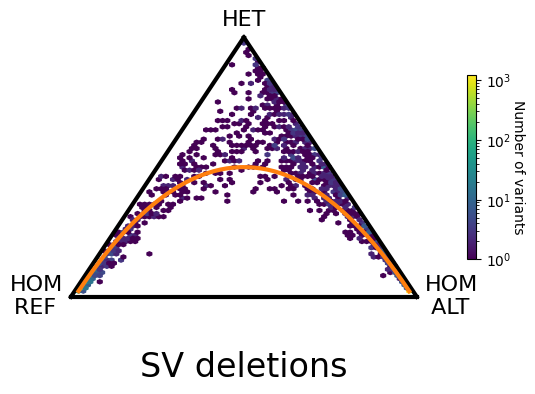

In [20]:
altlen, num_alt_alleles_v, gt_vsp = get_hist_data(concat_af_split_mergehap_vcf_gz)
is_sv_ins = altlen >= 50
is_sv_del = altlen <= -50

_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp, title='All variants', show=True)
_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp[is_sv_ins], title='SV insertions', show=True)
_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp[is_sv_del], title='SV deletions', show=True)

Loading /home/jupyter/AoU1-v1/run-from-callset/chr1.concat-atomize.af.prepare.id.split.mergehap.unmergehap.vcf...


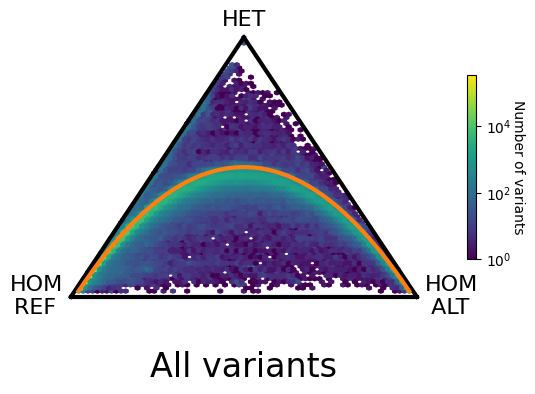

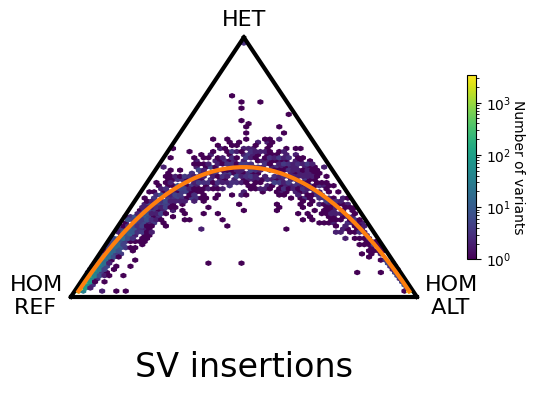

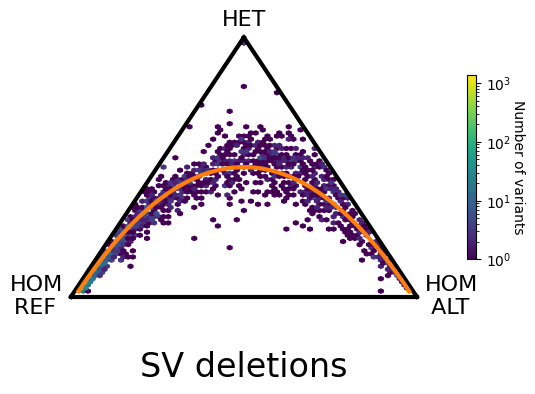

In [28]:
altlen, num_alt_alleles_v, gt_vsp = get_hist_data(concat_af_split_mergehap_unmergehap_vcf)
is_sv_ins = altlen >= 50
is_sv_del = altlen <= -50

_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp, title='All variants', show=True)
_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp[is_sv_ins], title='SV insertions', show=True)
_ = plot_de_finetti(make_de_finetti_ax(), gt_vsp[is_sv_del], title='SV deletions', show=True)

In [ ]:
# ! bcftools stats /home/jupyter/AoU1-v1/hiphase-outputs/chr22_scaffold.bcf | grep SN

In [ ]:
# ! bcftools stats /home/jupyter/AoU1-v1/hiphase-outputs/chr22_finalsv_scaffold.bcf | grep SN

In [ ]:
# ! bcftools stats /home/jupyter/AoU1-v1/preprocess/chr22.concat.vcf.gz | grep SN

In [ ]:
# ! bcftools stats /home/jupyter/AoU1-v1/preprocess/chr22.concat.af.vcf.gz | grep SN

In [ ]:
# ! bcftools stats {concat_af_split_vcf_gz} | grep SN

In [ ]:
# ! bcftools stats {concat_af_split_mergehap_vcf_gz} | grep SN